In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np


In [2]:
# Load the data
data = pd.read_csv('./clinicalData2.csv')
# Display the first few rows of the dataset to understand its structure
data.head()

,subject_id,stay_id,hadm_id,hospital_expire_flag,dod,gender,admission_age,hematocrit_min,hematocrit_max,hemoglobin_min,...,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,19452423,33252269,28656889,0,NaN,M,59,21.4,25.6,7.2,...,12.555556,36.50,36.89,36.667143,100.0,100.0,100.000000,151.0,180.0,163.800000
1,18607896,34323529,21419235,0,2129-09-01,M,59,28.4,30.7,9.6,...,16.760000,35.72,36.44,36.146667,88.0,100.0,94.600000,135.0,178.0,160.000000
2,19655491,32465570,23321342,1,2173-06-14,F,55,14.1,30.5,4.6,...,17.092593,35.17,36.39,35.806250,98.0,100.0,99.259259,76.0,144.0,103.750000
3,10666659,35745198,23457167,1,2143-12-02,F,53,26.0,31.9,8.5,...,20.615385,35.56,36.67,35.977143,93.0,99.0,95.347826,76.0,109.0,92.500000
4,12668169,31574288,23898774,1,2156-08-19,M,54,21.8,23.1,7.6,...,21.472973,34.40,36.89,36.075714,90.0,100.0,96.540541,85.0,103.0,95.666667


In [3]:
#X = data.drop(columns=['subject_id', 'stay_id', 'hadm_id', 'hospital_expire_flag'])
X = data.drop(columns=['subject_id', 'stay_id', 'hadm_id', 'dod'])
#X = X.fillna(X.mean())
X = X.fillna(-1)
X.head()

,hospital_expire_flag,gender,admission_age,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,...,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,0,M,59,21.4,25.6,7.2,8.6,87.0,124.0,8.1,...,12.555556,36.50,36.89,36.667143,100.0,100.0,100.000000,151.0,180.0,163.800000
1,0,M,59,28.4,30.7,9.6,9.8,83.0,102.0,8.7,...,16.760000,35.72,36.44,36.146667,88.0,100.0,94.600000,135.0,178.0,160.000000
2,1,F,55,14.1,30.5,4.6,10.9,81.0,146.0,8.9,...,17.092593,35.17,36.39,35.806250,98.0,100.0,99.259259,76.0,144.0,103.750000
3,1,F,53,26.0,31.9,8.5,8.5,163.0,173.0,15.8,...,20.615385,35.56,36.67,35.977143,93.0,99.0,95.347826,76.0,109.0,92.500000
4,1,M,54,21.8,23.1,7.6,8.1,64.0,98.0,10.5,...,21.472973,34.40,36.89,36.075714,90.0,100.0,96.540541,85.0,103.0,95.666667


In [4]:
#X = data.drop('target', axis=1).values
#X = data.drop(columns=['subject_id', 'stay_id', 'hadm_id', 'hospital_expire_flag', 'subject_id_1'])
#X = X.fillna(X.mean())
le = LabelEncoder()
X['gender'] = le.fit_transform(X['gender'])
#y = data['target'].values
y = data['dod'].notnull().astype(int)
#y = data['hospital_expire_flag']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#for data, targets in train_loader:
#    print(data, targets)

## MLP

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(112, 64)  # 112 features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = BinaryClassifier()
criterion = nn.BCELoss()

## ResNet

In [11]:
class ResNetTabular(nn.Module):
    def __init__(self, num_features, num_classes=1):
        super(ResNetTabular, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(2)
        x = self.resnet(x)
        #print(x.shape)
        return x

model = ResNetTabular(num_features=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()

/home/cnelabai/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cnelabai/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## U-Net

In [17]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, ks=7):
        super().__init__()
        padding = int((ks - 1) / 2)

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv1d(in_channels, middle_channels, kernel_size=ks, padding=padding)
        self.bn1 = nn.BatchNorm1d(middle_channels)
        self.conv2 = nn.Conv1d(middle_channels, out_channels, kernel_size=ks, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out
    
class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=1, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool1d(2)
        #self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)

        # input_channel => 32; 32 => 64; 64=>128; 128=>256
        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        
        
        self.fc1 = nn.Linear(512, 64)  # 112 features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        #self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        #self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        #self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        #self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        #self.final = nn.Conv1d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, x):
        x = x.unsqueeze(1)
        #print(x.shape)
        x0_0 = self.conv0_0(x)
        #print(x0_0.shape)
        x1_0 = self.conv1_0(self.pool(x0_0))
        #print(x1_0.shape)
        x2_0 = self.conv2_0(self.pool(x1_0))
        #print(x2_0.shape)
        x3_0 = self.conv3_0(self.pool(x2_0))
        #print(x3_0.shape)
        x4_0 = self.conv4_0(self.pool(x3_0))
        #print(x4_0.shape)
        x_pool = self.adaptive_pool(x4_0)
        #print(x_pool.shape)
        x_flattened = x_pool.view(x_pool.size(0), -1)
        #print(x_flattened.shape)
        x = torch.relu(self.fc1(x_flattened))
        x = torch.relu(self.fc2(x))
        output = self.sigmoid(self.fc3(x))
        #x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        #x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_0)], 1))
        #x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        #x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        #output = self.final(x0_4)
        return output

model = UNet(num_classes=1)
criterion = nn.BCEWithLogitsLoss()

## UNet ver2.

In [29]:
class UNet(nn.Module):
    def __init__(self, num_features):
        super(UNet, self).__init__()
        # Contracting Path (Encoder)
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)

        # Expanding Path (Decoder)
        self.dec_conv1 = nn.Conv1d(32, 16, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv1d(16, 1, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Output layer
        self.output_layer = nn.Linear(num_features, 1)  # Adjust the size as needed

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding a channel dimension

        # Encoder
        x1 = self.pool(torch.relu(self.enc_conv1(x)))
        x2 = self.pool(torch.relu(self.enc_conv2(x1)))

        # Decoder
        x3 = self.upsample(x2)
        x3 = torch.relu(self.dec_conv1(x3))
        x4 = self.upsample(x3)
        x4 = torch.relu(self.dec_conv2(x4))

        # Flatten and pass through the output layer
        x4 = x4.squeeze(1)  # Removing the channel dimension
        x4 = x4.view(x4.size(0), -1)  # Flatten
        out = torch.sigmoid(self.output_layer(x4))

        return out

model = UNet(num_features=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()

In [33]:
# Loss function
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


UNet(
  (enc_conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc_conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec_conv2): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (output_layer): Linear(in_features=112, out_features=1, bias=True)
)

In [34]:
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for data, targets in train_loader:
            #data, targets = data.to(device), targets.to(device)
            data, targets = data.to(device), targets.view(-1, 1).to(device)
            #print(data.shape)
            # Forward pass
            outputs = model(data)
            #loss = criterion(outputs.squeeze(), targets)
            #print("outputs:", outputs.shape)
            #print("targets:", targets.shape)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(num_epochs=100)


Epoch [1/100], Loss: 0.4445
Epoch [2/100], Loss: 0.5179
Epoch [3/100], Loss: 0.5441
Epoch [4/100], Loss: 0.4886
Epoch [5/100], Loss: 0.5220
Epoch [6/100], Loss: 0.5484
Epoch [7/100], Loss: 0.5765
Epoch [8/100], Loss: 0.5470
Epoch [9/100], Loss: 0.5949
Epoch [10/100], Loss: 0.4010
Epoch [11/100], Loss: 0.5765
Epoch [12/100], Loss: 0.3429
Epoch [13/100], Loss: 0.5178
Epoch [14/100], Loss: 0.6240
Epoch [15/100], Loss: 0.6054
Epoch [16/100], Loss: 0.5771
Epoch [17/100], Loss: 0.5470
Epoch [18/100], Loss: 0.5186
Epoch [19/100], Loss: 0.4630
Epoch [20/100], Loss: 0.5772
Epoch [21/100], Loss: 0.4887
Epoch [22/100], Loss: 0.3750
Epoch [23/100], Loss: 0.3731
Epoch [24/100], Loss: 0.4595
Epoch [25/100], Loss: 0.5178
Epoch [26/100], Loss: 0.4893
Epoch [27/100], Loss: 0.5502
Epoch [28/100], Loss: 0.4302
Epoch [29/100], Loss: 0.5178
Epoch [30/100], Loss: 0.5182
Epoch [31/100], Loss: 0.5763
Epoch [32/100], Loss: 0.4009
Epoch [33/100], Loss: 0.5763
Epoch [34/100], Loss: 0.4320
Epoch [35/100], Loss: 0

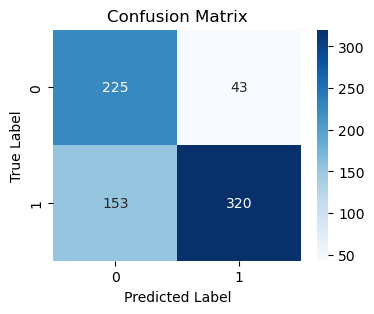

Accuracy of the model on the test set: 73.51%
Precision of the model on the test set: 88.15%
Recall of the model on the test set: 67.65%
F1 of the model on the test set: 76.56%


In [35]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    true_y = np.zeros(1, dtype=int)
    pred_y = np.zeros(1, dtype=int)

    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        predicted = (outputs.squeeze() > 0.5).float()
        
        numpy_array1 = targets.detach().cpu().numpy().astype(int)
        true_y = np.concatenate((true_y, numpy_array1))
        #print(true_y.shape)
        
        numpy_array2 = predicted.detach().cpu().numpy().astype(int)
        pred_y = np.concatenate((pred_y, numpy_array2))
        #print(pred_y.shape)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        tp += ((predicted == 1) & (targets == 1)).sum().item()
        fp += ((predicted == 1) & (targets == 0)).sum().item()
        fn += ((predicted == 0) & (targets == 1)).sum().item()

    precision = 100 * tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    
    cm = confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')
    print(f'Precision of the model on the test set: {precision:.2f}%')
    print(f'Recall of the model on the test set: {recall:.2f}%')
    print(f'F1 of the model on the test set: {f1:.2f}%')


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


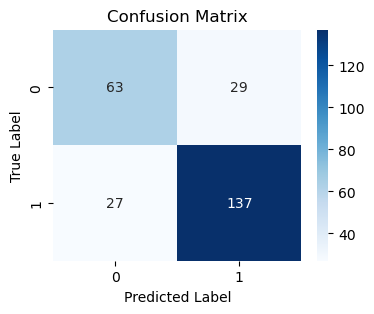

Confusion Matrix:
 [[ 63  27]
 [ 29 137]]

Accuracy, Precision, Recall, F1:
0.781250, 0.825301, 0.835366, 0.830303



In [42]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

X, y = load_breast_cancer(return_X_y=True)
#print(X.shape)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tensor[0:1280,0:100], y_tensor[0:1280], test_size=0.2, random_state=42)


# N_ensemble_configurations controls the number of model predictions that are ensembled with feature and class rotations (See our work for details).
# When N_ensemble_configurations > #features * #classes, no further averaging is applied.

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

#accuracy = accuracy_score(y_test, y_eval)
#print('Accuracy', accuracy)

cm = confusion_matrix(y_test, y_eval)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print('Confusion Matrix:\n', confusion_matrix(y_test, y_eval).T)
accuracy = accuracy_score(y_test, y_eval)
precision = precision_score(y_test, y_eval)
recall = recall_score(y_test, y_eval)
f1 = f1_score(y_test, y_eval)
print('\nAccuracy, Precision, Recall, F1:')
print(f'{accuracy:4f}, {precision:4f}, {recall:4f}, {f1:4f}\n')